# 5. The mechanics of learning
This chapter covers
* Understanding how algorithms can learn from data
* Reframing learning as parameter estimation, using differentiation and gradient descent
* Walking through a simple learning algorithm
* How PyTorch supports learning with autograd

Building models that allow us to explain input/output relationships dates back centuries at least. When Johannes Kepler, a German mathematical astronomer (1571–1630), figured out his three laws of planetary motion in the early 1600s, he based them on data collected by his mentor Tycho Brahe during naked-eye observations (yep, seen with the naked eye and written on a piece of paper). Not having Newton’s law of gravitation at his disposal (actually, Newton used Kepler’s work to figure things out), Kepler extrapolated the simplest possible geometric model that could fit the data. And, by the way, it took him six years of staring at data that didn’t make sense to him, together with incremental realizations, to finally formulate these laws. 1 We can see this process in figure 5.1.

![](images/5.1.png)
Figure 5.1 Johannes Kepler considers multiple candidate models that might fit the data at hand, settling on an ellipse.

Kepler’s first law reads: “The orbit of every planet is an ellipse with the Sun at one of
the two foci.” He didn’t know what caused orbits to be ellipses, but given a set of observations for a planet (or a moon of a large planet, like Jupiter), he could estimate the
shape (the eccentricity) and size (the semi-latus rectum) of the ellipse. With those two
parameters computed from the data, he could tell where the planet might be during its journey in the sky. Once he figured out the second law—“A line joining a planet
and the Sun sweeps out equal areas during equal intervals of time”—he could also tell
when a planet would be at a particular point in space, given observations in time.

So, how did Kepler estimate the eccentricity and size of the ellipse without computers, pocket calculators, or even calculus, none of which had been invented yet? We
can learn how from Kepler’s own recollection, in his book New Astronomy, or from how
J. V. Field put it in his series of articles, “The origins of proof,” (http://mng.bz/9007)

So let’s sum things up. Over six years, Kepler

1. Got lots of good data from his friend Brahe (not without some struggle)
2. Tried to visualize the heck out of it, because he felt there was something fishy going on
3. Chose the simplest possible model that had a chance to fit the data (an ellipse)
4. Split the data so that he could work on part of it and keep an independent set for validation
5. Started with a tentative eccentricity and size for the ellipse and iterated until the model fit the observations
6. Validated his model on the independent observations
7. Looked back in disbelief

## 5.2 Learning is just parameter estimation
Figure 5.2 shows the high-level overview of what we’ll implement by the end of the chapter. Given input data and the corresponding desired outputs (ground truth), as well as initial values for the weights, the model is fed input data (forward pass), and a measure of the error is evaluated by comparing the resulting outputs to the ground truth. In order to optimize the parameter of the model—its weights—the change in the error following a unit change in weights (that is, the gradient of the error with respect to the parameters) is computed using the chain rule for the derivative of a composite function (backward pass). The value of the weights is then updated in the direction that leads to a decrease in the error. The procedure is repeated until the error, evaluated on unseen data, falls below an acceptable level. If what we just said sounds obscure, we’ve got a whole chapter to clear things up. By the time we’re done, all the pieces will fall into place, and this paragraph will make perfect sense.

![](images/5.2.png)

### 5.2.1 A hot problem
We just got back from a trip to some obscure location, and we brought back a fancy,
wall-mounted analog thermometer. It looks great, and it’s a perfect fit for our living
room. Its only flaw is that it doesn’t show units. Not to worry, we’ve got a plan: we’ll
build a dataset of readings and corresponding temperature values in our favorite
units, choose a model, adjust its weights iteratively until a measure of the error is low
enough, and finally be able to interpret the new readings in units we understand.

### 5.2.2 Gathering some data
We’ll start by making a note of temperature data in good old Celsius 5 and measure-
ments from our new thermometer, and figure things out. After a couple of weeks,
here’s the data (code/p1ch5/1_parameter_estimation.ipynb):

In [1]:
import torch

t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Here, the `t_c` values are temperatures in Celsius, and the `t_u` values are our unknown
units. We can expect noise in both measurements, coming from the devices themselves and from our approximate readings. For convenience, we’ve already put the
data into tensors; we’ll use it in a minute.

### 5.2.3 Visualizing the data
A quick plot of our data in figure 5.3 tells us that it’s noisy, but we think there’s a pattern here.

### 5.2.4 Choosing a linear model as a first try
In the absence of further knowledge, we assume the simplest possible model for converting between the two sets of measurements, just like Kepler might have done. The two may be linearly related—that is, multiplying `t_u` by a factor and adding a constant, we may get the temperature in Celsius (up to an error that we omit):

$t_c = w * t_u + b$

Is this a reasonable assumption? Probably; we’ll see how well the final model per-
forms. We chose to name `w` and `b` after *weight* and *bias*, two very common terms for linear scaling and the additive constant—we’ll bump into those all the time.

OK, now we need to estimate `w` and `b` , the parameters in our model, based on the data we have. We must do it so that temperatures we obtain from running the unknown temperatures `t_u` through the model are close to temperatures we actually measured in Celsius. If that sounds like fitting a line through a set of measurements, well, yes, because that’s exactly what we’re doing.

Let’s flesh it out again: we have a model with some unknown parameters, and we need to estimate those parameters so that the error between predicted outputs and measured values is as low as possible. We notice that we still need to exactly define a measure of the error. Such a measure, which we refer to as the *loss function*, should be high if the error is high and should ideally be as low as possible for a perfect match. Our optimization process should therefore aim at finding `w` and `b` so that the loss function is at a minimum.

## 5.3 Less loss is what we want
A *loss function* (or *cost function*) is a function that computes a single numerical value that the learning process will attempt to minimize. The calculation of loss typically involves taking the difference between the desired outputs for some training samples and the outputs actually produced by the model when fed those samples. In our case, that would be the difference between the predicted temperatures `t_p` output by our model and the actual measurements: `t_p` – `t_c` .

We need to make sure the loss function makes the loss positive both when t_p is greater than and when it is less than the true `t_c` , since the goal is for t_p to match t_c . We have a few choices, the most straightforward being `|t_p – t_c|` and `(t_p – t_c)^2`.

Both of the example loss functions have a clear minimum at zero and grow monotonically as the predicted value moves further from the true value in either direction. Because the steepness of the growth also monotonically increases away from the minimum, both of them are said to be *convex*. Since our model is linear, the loss as a function of w and b is also convex. Cases where the loss is a convex function of the model parameters are usually great to deal with because we can find a minimum very efficiently through specialized algorithms.

For our two loss functions `|t_p – t_c|` and `(t_p – t_c)^2` , as shown in figure 5.4, we notice that the square of the differences behaves more nicely around the minimum: the derivative of the error-squared loss with respect to `t_p` is zero when `t_p` equals `t_c` . The absolute value, on the other hand, has an undefined derivative right where we’d like to converge. This is less of an issue in practice than it looks like, but we’ll stick to the square of differences for the time being.

![](images/5.3.png)

It’s worth noting that the square difference also penalizes wildly wrong results more than
the absolute difference does. Often, having more slightly wrong results is better than hav-
ing a few wildly wrong ones, and the squared difference helps prioritize those as desired.

### 5.3.1 From problem back to PyTorch
We’ve already created our data tensors, so now let’s write out the model as a
Python function:

In [2]:
def model(t_u, w, b):
    return w * t_u + b

We’re expecting `t_u` , `w` , and `b` to be the input tensor, weight parameter, and bias
parameter, respectively. In our model, the parameters will be PyTorch scalars (akaLess
zero-dimensional tensors), and the product operation will use broadcasting to yield
the returned tensors. Anyway, time to define our loss:

In [3]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Note that we are building a tensor of differences, taking their square element-wise,
and finally producing a scalar loss function by averaging all of the elements in the
resulting tensor. It is a *mean square loss*.
We can now initialize the parameters, invoke the model,

In [4]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

and check the value of the loss:

In [5]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

## 5.4 Down along the gradient
We’ll optimize the loss function with respect to the parameters using the *gradient descent* algorithm. In this section, we’ll build our intuition for how gradient descent works from first principles, which will help us a lot in the future. 

### 5.4.1 Decreasing loss
Gradient descent is not that different from the scenario we just described. The idea is
to compute the rate of change of the loss with respect to each parameter, and modify
each parameter in the direction of decreasing loss. Just like when we were fiddling
with the knobs, we can estimate the rate of change by adding a small number to `w` and
`b` and seeing how much the loss changes in that neighborhood:

In [6]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c)-
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

This is saying that in the neighborhood of the current values of `w` and `b` , a unit increase in `w` leads to some change in the loss. If the change is negative, then we need to increase `w` to minimize the loss, whereas if the change is positive, we need to decrease `w` . By how much? Applying a change to `w` that is proportional to the rate of change of the loss is a good idea, especially when the loss has several parameters: we apply a change to those that exert a significant change on the loss. It is also wise to change the parameters slowly in general, because the rate of change could be dramatically different at a distance from the neighborhood of the current w value. Therefore, we typically should scale the rate of change by a small factor. This scaling factor has many names; the one we use in machine learning is `learning_rate` :

In [7]:
learning_rate = 1e-2

w = w - learning_rate*loss_rate_of_change_w

We can do the same with `b`:

In [8]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) -
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

This represents the basic parameter-update step for gradient descent. By reiterating these evaluations (and provided we choose a small enough learning rate), we will converge to an optimal value of the parameters for which the loss computed on the given data is minimal. We’ll show the complete iterative process soon, but the way we just computed our rates of change is rather crude and needs an upgrade before we move on.

### 5.4.2 Getting analytical
What if we could make the neighborhood infinitesimally small, as in figure 5.6?
That’s exactly what happens when we analytically take the derivative of the loss with
respect to a parameter. In a model with two or more parameters like the one we’re
dealing with, we compute the individual derivatives of the loss with respect to each
parameter and put them in a vector of derivatives: the gradient.

![](images/5.4.png)

**COMPUTING THE DERIVATIVES**

In order to compute the derivative of the loss with respect to a parameter, we can
apply the chain rule and compute the derivative of the loss with respect to its input
(which is the output of the model), times the derivative of the model with respect to
the parameter: $d loss_{fn} / dw = (d loss_{fn} / d t_p) * (d t_p / d w)$

In [9]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [10]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

**A PPLYING THE DERIVATIVES TO THE MODEL**

For the model, recalling that our model is

In [11]:
def model(t_u, w, b):
    return w * t_u + b

In [12]:
def dmodel_dw(t_u, w, b):
    return t_u

In [13]:
def dmodel_db(t_u, w, b):
    return 1.0

**DEFINING THE GRADIENT FUNCTION**

Putting all of this together, the function returning the gradient of the loss with respect
to $w$ and $b$ is

In [14]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

The same idea expressed in mathematical notation is shown in figure 5.7. Again, we’re averaging (that is, summing and dividing by a constant) over all the data points to get a single scalar quantity for each partial derivative of the loss.

![](images/5.5.png)

### 5.4.3 Iterating to fit the model
We now have everything in place to optimize our parameters. Starting from a tentative
value for a parameter, we can iteratively apply updates to it for a fixed number of iter-
ations, or until w and b stop changing. There are several stopping criteria; for now,
we’ll stick to a fixed number of iterations.

**THE TRAINING LOOP**

Since we’re at it, let’s introduce another piece of terminology. We call a training itera-
tion during which we update the parameters for all of our training samples an `epoch`. The complete training loop looks like this (code/p1ch5/1_parameter_estimation
.ipynb):

In [15]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b)             # Forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)# Backward pass
        params = params - learning_rate * grad
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [16]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 5802484.500000
Epoch 3, Loss 19408029696.000000
Epoch 4, Loss 64915905708032.000000
Epoch 5, Loss 217130525461053440.000000
Epoch 6, Loss 726257583152928129024.000000
Epoch 7, Loss 2429183416467662896627712.000000
Epoch 8, Loss 8125122549611731432050262016.000000
Epoch 9, Loss 27176882120842590626938030653440.000000
Epoch 10, Loss 90901105189019073810297959556841472.000000
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf
Epoch 21, Loss inf
Epoch 22, Loss inf
Epoch 23, Loss nan
Epoch 24, Loss nan
Epoch 25, Loss nan
Epoch 26, Loss nan
Epoch 27, Loss nan
Epoch 28, Loss nan
Epoch 29, Loss nan
Epoch 30, Loss nan
Epoch 31, Loss nan
Epoch 32, Loss nan
Epoch 33, Loss nan
Epoch 34, Loss nan
Epoch 35, Loss nan
Epoch 36, Loss nan
Epoch 37, Loss nan
Epoch 38, Loss nan
Epoch 39, Loss nan
Epoch 40, Loss nan
Epoch 41, Loss

tensor([nan, nan])

**OVERTRAINING**

Wait, what happened? Our training process literally blew up, leading to losses becom-
ing inf . This is a clear sign that params is receiving updates that are too large, and
their values start oscillating back and forth as each update overshoots and the next
overcorrects even more. The optimization process is unstable: it `diverges` instead of
converging to a minimum. We want to see smaller and smaller updates to `params` , not
larger, as shown in figure 5.8.

![](images/5.6.png)
Figure 5.8 Top: Diverging optimization on a convex function (parabola-like) due to large steps. Bottom: Converging optimization with small steps.

How can we limit the magnitude of `learning_rate * grad` ? Well, that looks easy. We
could simply choose a smaller learning_rate , and indeed, the learning rate is one of
the things we typically change when training does not go as well as we would like. 8 We
usually change learning rates by orders of magnitude, so we might try with `1e-3` or
`1e-4` , which would decrease the magnitude of the updates by orders of magnitude.
Let’s go with `1e-4` and see how it works out:

In [17]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 323.090515
Epoch 3, Loss 78.929634
Epoch 4, Loss 37.552845
Epoch 5, Loss 30.540283
Epoch 6, Loss 29.351154
Epoch 7, Loss 29.148884
Epoch 8, Loss 29.113848
Epoch 9, Loss 29.107145
Epoch 10, Loss 29.105247
Epoch 11, Loss 29.104168
Epoch 12, Loss 29.103222
Epoch 13, Loss 29.102295
Epoch 14, Loss 29.101379
Epoch 15, Loss 29.100466
Epoch 16, Loss 29.099548
Epoch 17, Loss 29.098631
Epoch 18, Loss 29.097717
Epoch 19, Loss 29.096796
Epoch 20, Loss 29.095881
Epoch 21, Loss 29.094959
Epoch 22, Loss 29.094049
Epoch 23, Loss 29.093134
Epoch 24, Loss 29.092216
Epoch 25, Loss 29.091301
Epoch 26, Loss 29.090385
Epoch 27, Loss 29.089464
Epoch 28, Loss 29.088551
Epoch 29, Loss 29.087635
Epoch 30, Loss 29.086714
Epoch 31, Loss 29.085804
Epoch 32, Loss 29.084888
Epoch 33, Loss 29.083967
Epoch 34, Loss 29.083057
Epoch 35, Loss 29.082142
Epoch 36, Loss 29.081221
Epoch 37, Loss 29.080309
Epoch 38, Loss 29.079390
Epoch 39, Loss 29.078474
Epoch 40, Loss 29.077562
Epoch 

tensor([ 0.2327, -0.0438])

Nice—the behavior is now stable. But there’s another problem: the updates to param-
eters are very small, so the loss decreases very slowly and eventually stalls. We could
obviate this issue by making `learning_rate` adaptive: that is, change according to the
magnitude of updates. There are optimization schemes that do that, and we’ll see one
toward the end of this chapter, in section 5.5.2.
However, there’s another potential troublemaker in the update term: the gradient
itself. Let’s go back and look at `grad` at epoch 1 during optimization.

### 5.4.4 Normalizing inputs
We can see that the first-epoch gradient for the weight is about 50 times larger than
the gradient for the bias. This means the weight and bias live in differently scaled
spaces. If this is the case, a learning rate that’s large enough to meaningfully update
one will be so large as to be unstable for the other; and a rate that’s appropriate for
the other won’t be large enough to meaningfully change the first. That means we’re
not going to be able to update our parameters unless we change something about our
formulation of the problem. We could have individual learning rates for each parame-
ter, but for models with many parameters, this would be too much to bother with; it’s
babysitting of the kind we don’t like.

There’s a simpler way to keep things in check: changing the inputs so that the gra-
dients aren’t quite so different. We can make sure the range of the input doesn’t get
too far from the range of – 1.0 to 1.0, roughly speaking. In our case, we can achieve
something close enough to that by simply multiplying `t_u` by `0.1`:

In [18]:
t_un = 0.1 * t_u

training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507153
Epoch 6, Loss 29.392456
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119415
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765553
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503319
Epoch 17, Loss 28.416498
Epoch 18, Loss 28.329973
Epoch 19, Loss 28.243742
Epoch 20, Loss 28.157804
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986797
Epoch 23, Loss 27.901728
Epoch 24, Loss 27.816950
Epoch 25, Loss 27.732464
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564344
Epoch 28, Loss 27.480707
Epoch 29, Loss 27.397362
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149010
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903175
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740679
Epoch 38, Loss 26.659838
Epoch 39, Loss 26.579279
Epoch 40, Loss 26.498987
Epoch 41,

tensor([ 2.7553, -2.5162])

Even though we set our learning rate back to `1e-2` , parameters don’t blow up during
iterative updates. Let’s take a look at the gradients: they’re of similar magnitude, so
using a single `learning_rate` for both parameters works just fine. We could probably
do a better job of normalization than a simple rescaling by a factor of 10, but since
doing so is good enough for our needs, we’re going to stick with that for now.

Let’s run the loop for enough iterations to see the changes in params get small. We’ll
change `n_epochs` to `5,000`:

In [19]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)
params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507153
Epoch 6, Loss 29.392456
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119415
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765553
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503319
Epoch 17, Loss 28.416498
Epoch 18, Loss 28.329973
Epoch 19, Loss 28.243742
Epoch 20, Loss 28.157804
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986797
Epoch 23, Loss 27.901728
Epoch 24, Loss 27.816950
Epoch 25, Loss 27.732464
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564344
Epoch 28, Loss 27.480707
Epoch 29, Loss 27.397362
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149010
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903175
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740679
Epoch 38, Loss 26.659838
Epoch 39, Loss 26.579279
Epoch 40, Loss 26.498987
Epoch 41,

Epoch 415, Loss 9.513184
Epoch 416, Loss 9.490829
Epoch 417, Loss 9.468551
Epoch 418, Loss 9.446347
Epoch 419, Loss 9.424216
Epoch 420, Loss 9.402164
Epoch 421, Loss 9.380184
Epoch 422, Loss 9.358282
Epoch 423, Loss 9.336448
Epoch 424, Loss 9.314695
Epoch 425, Loss 9.293012
Epoch 426, Loss 9.271403
Epoch 427, Loss 9.249871
Epoch 428, Loss 9.228410
Epoch 429, Loss 9.207022
Epoch 430, Loss 9.185704
Epoch 431, Loss 9.164462
Epoch 432, Loss 9.143289
Epoch 433, Loss 9.122189
Epoch 434, Loss 9.101160
Epoch 435, Loss 9.080204
Epoch 436, Loss 9.059318
Epoch 437, Loss 9.038502
Epoch 438, Loss 9.017757
Epoch 439, Loss 8.997084
Epoch 440, Loss 8.976479
Epoch 441, Loss 8.955944
Epoch 442, Loss 8.935480
Epoch 443, Loss 8.915089
Epoch 444, Loss 8.894762
Epoch 445, Loss 8.874508
Epoch 446, Loss 8.854318
Epoch 447, Loss 8.834197
Epoch 448, Loss 8.814149
Epoch 449, Loss 8.794162
Epoch 450, Loss 8.774253
Epoch 451, Loss 8.754405
Epoch 452, Loss 8.734623
Epoch 453, Loss 8.714911
Epoch 454, Loss 8.695266


Epoch 745, Loss 5.071781
Epoch 746, Loss 5.064505
Epoch 747, Loss 5.057247
Epoch 748, Loss 5.050021
Epoch 749, Loss 5.042817
Epoch 750, Loss 5.035636
Epoch 751, Loss 5.028476
Epoch 752, Loss 5.021346
Epoch 753, Loss 5.014240
Epoch 754, Loss 5.007157
Epoch 755, Loss 5.000099
Epoch 756, Loss 4.993064
Epoch 757, Loss 4.986051
Epoch 758, Loss 4.979064
Epoch 759, Loss 4.972100
Epoch 760, Loss 4.965159
Epoch 761, Loss 4.958245
Epoch 762, Loss 4.951351
Epoch 763, Loss 4.944479
Epoch 764, Loss 4.937633
Epoch 765, Loss 4.930812
Epoch 766, Loss 4.924009
Epoch 767, Loss 4.917234
Epoch 768, Loss 4.910480
Epoch 769, Loss 4.903749
Epoch 770, Loss 4.897040
Epoch 771, Loss 4.890356
Epoch 772, Loss 4.883692
Epoch 773, Loss 4.877052
Epoch 774, Loss 4.870436
Epoch 775, Loss 4.863839
Epoch 776, Loss 4.857268
Epoch 777, Loss 4.850718
Epoch 778, Loss 4.844189
Epoch 779, Loss 4.837683
Epoch 780, Loss 4.831196
Epoch 781, Loss 4.824737
Epoch 782, Loss 4.818298
Epoch 783, Loss 4.811879
Epoch 784, Loss 4.805481


Epoch 1266, Loss 3.292276
Epoch 1267, Loss 3.291036
Epoch 1268, Loss 3.289804
Epoch 1269, Loss 3.288573
Epoch 1270, Loss 3.287347
Epoch 1271, Loss 3.286129
Epoch 1272, Loss 3.284911
Epoch 1273, Loss 3.283698
Epoch 1274, Loss 3.282488
Epoch 1275, Loss 3.281284
Epoch 1276, Loss 3.280085
Epoch 1277, Loss 3.278888
Epoch 1278, Loss 3.277696
Epoch 1279, Loss 3.276506
Epoch 1280, Loss 3.275322
Epoch 1281, Loss 3.274142
Epoch 1282, Loss 3.272968
Epoch 1283, Loss 3.271793
Epoch 1284, Loss 3.270625
Epoch 1285, Loss 3.269460
Epoch 1286, Loss 3.268301
Epoch 1287, Loss 3.267143
Epoch 1288, Loss 3.265991
Epoch 1289, Loss 3.264842
Epoch 1290, Loss 3.263700
Epoch 1291, Loss 3.262556
Epoch 1292, Loss 3.261421
Epoch 1293, Loss 3.260287
Epoch 1294, Loss 3.259160
Epoch 1295, Loss 3.258033
Epoch 1296, Loss 3.256912
Epoch 1297, Loss 3.255795
Epoch 1298, Loss 3.254681
Epoch 1299, Loss 3.253569
Epoch 1300, Loss 3.252462
Epoch 1301, Loss 3.251362
Epoch 1302, Loss 3.250263
Epoch 1303, Loss 3.249168
Epoch 1304, 

Epoch 1644, Loss 3.028486
Epoch 1645, Loss 3.028142
Epoch 1646, Loss 3.027802
Epoch 1647, Loss 3.027463
Epoch 1648, Loss 3.027122
Epoch 1649, Loss 3.026784
Epoch 1650, Loss 3.026447
Epoch 1651, Loss 3.026111
Epoch 1652, Loss 3.025780
Epoch 1653, Loss 3.025447
Epoch 1654, Loss 3.025114
Epoch 1655, Loss 3.024782
Epoch 1656, Loss 3.024452
Epoch 1657, Loss 3.024125
Epoch 1658, Loss 3.023796
Epoch 1659, Loss 3.023471
Epoch 1660, Loss 3.023145
Epoch 1661, Loss 3.022820
Epoch 1662, Loss 3.022498
Epoch 1663, Loss 3.022177
Epoch 1664, Loss 3.021855
Epoch 1665, Loss 3.021534
Epoch 1666, Loss 3.021217
Epoch 1667, Loss 3.020898
Epoch 1668, Loss 3.020582
Epoch 1669, Loss 3.020265
Epoch 1670, Loss 3.019952
Epoch 1671, Loss 3.019639
Epoch 1672, Loss 3.019325
Epoch 1673, Loss 3.019016
Epoch 1674, Loss 3.018706
Epoch 1675, Loss 3.018395
Epoch 1676, Loss 3.018089
Epoch 1677, Loss 3.017780
Epoch 1678, Loss 3.017475
Epoch 1679, Loss 3.017170
Epoch 1680, Loss 3.016867
Epoch 1681, Loss 3.016564
Epoch 1682, 

Epoch 2120, Loss 2.947628
Epoch 2121, Loss 2.947560
Epoch 2122, Loss 2.947494
Epoch 2123, Loss 2.947426
Epoch 2124, Loss 2.947357
Epoch 2125, Loss 2.947293
Epoch 2126, Loss 2.947225
Epoch 2127, Loss 2.947158
Epoch 2128, Loss 2.947092
Epoch 2129, Loss 2.947026
Epoch 2130, Loss 2.946960
Epoch 2131, Loss 2.946895
Epoch 2132, Loss 2.946830
Epoch 2133, Loss 2.946764
Epoch 2134, Loss 2.946700
Epoch 2135, Loss 2.946635
Epoch 2136, Loss 2.946571
Epoch 2137, Loss 2.946507
Epoch 2138, Loss 2.946442
Epoch 2139, Loss 2.946378
Epoch 2140, Loss 2.946314
Epoch 2141, Loss 2.946251
Epoch 2142, Loss 2.946189
Epoch 2143, Loss 2.946126
Epoch 2144, Loss 2.946063
Epoch 2145, Loss 2.946001
Epoch 2146, Loss 2.945937
Epoch 2147, Loss 2.945876
Epoch 2148, Loss 2.945815
Epoch 2149, Loss 2.945753
Epoch 2150, Loss 2.945690
Epoch 2151, Loss 2.945630
Epoch 2152, Loss 2.945567
Epoch 2153, Loss 2.945508
Epoch 2154, Loss 2.945447
Epoch 2155, Loss 2.945385
Epoch 2156, Loss 2.945325
Epoch 2157, Loss 2.945267
Epoch 2158, 

Epoch 2474, Loss 2.933643
Epoch 2475, Loss 2.933622
Epoch 2476, Loss 2.933602
Epoch 2477, Loss 2.933583
Epoch 2478, Loss 2.933561
Epoch 2479, Loss 2.933541
Epoch 2480, Loss 2.933521
Epoch 2481, Loss 2.933501
Epoch 2482, Loss 2.933480
Epoch 2483, Loss 2.933463
Epoch 2484, Loss 2.933442
Epoch 2485, Loss 2.933422
Epoch 2486, Loss 2.933403
Epoch 2487, Loss 2.933382
Epoch 2488, Loss 2.933365
Epoch 2489, Loss 2.933345
Epoch 2490, Loss 2.933325
Epoch 2491, Loss 2.933306
Epoch 2492, Loss 2.933287
Epoch 2493, Loss 2.933266
Epoch 2494, Loss 2.933249
Epoch 2495, Loss 2.933229
Epoch 2496, Loss 2.933209
Epoch 2497, Loss 2.933190
Epoch 2498, Loss 2.933172
Epoch 2499, Loss 2.933154
Epoch 2500, Loss 2.933134
Epoch 2501, Loss 2.933116
Epoch 2502, Loss 2.933097
Epoch 2503, Loss 2.933079
Epoch 2504, Loss 2.933060
Epoch 2505, Loss 2.933043
Epoch 2506, Loss 2.933025
Epoch 2507, Loss 2.933007
Epoch 2508, Loss 2.932988
Epoch 2509, Loss 2.932970
Epoch 2510, Loss 2.932953
Epoch 2511, Loss 2.932932
Epoch 2512, 

Epoch 2830, Loss 2.929433
Epoch 2831, Loss 2.929427
Epoch 2832, Loss 2.929421
Epoch 2833, Loss 2.929415
Epoch 2834, Loss 2.929409
Epoch 2835, Loss 2.929404
Epoch 2836, Loss 2.929396
Epoch 2837, Loss 2.929391
Epoch 2838, Loss 2.929383
Epoch 2839, Loss 2.929380
Epoch 2840, Loss 2.929373
Epoch 2841, Loss 2.929368
Epoch 2842, Loss 2.929361
Epoch 2843, Loss 2.929356
Epoch 2844, Loss 2.929351
Epoch 2845, Loss 2.929344
Epoch 2846, Loss 2.929338
Epoch 2847, Loss 2.929332
Epoch 2848, Loss 2.929328
Epoch 2849, Loss 2.929321
Epoch 2850, Loss 2.929316
Epoch 2851, Loss 2.929309
Epoch 2852, Loss 2.929304
Epoch 2853, Loss 2.929300
Epoch 2854, Loss 2.929293
Epoch 2855, Loss 2.929288
Epoch 2856, Loss 2.929282
Epoch 2857, Loss 2.929277
Epoch 2858, Loss 2.929271
Epoch 2859, Loss 2.929266
Epoch 2860, Loss 2.929260
Epoch 2861, Loss 2.929255
Epoch 2862, Loss 2.929250
Epoch 2863, Loss 2.929244
Epoch 2864, Loss 2.929238
Epoch 2865, Loss 2.929234
Epoch 2866, Loss 2.929228
Epoch 2867, Loss 2.929222
Epoch 2868, 

Epoch 3225, Loss 2.928113
Epoch 3226, Loss 2.928110
Epoch 3227, Loss 2.928109
Epoch 3228, Loss 2.928108
Epoch 3229, Loss 2.928105
Epoch 3230, Loss 2.928105
Epoch 3231, Loss 2.928104
Epoch 3232, Loss 2.928102
Epoch 3233, Loss 2.928101
Epoch 3234, Loss 2.928098
Epoch 3235, Loss 2.928097
Epoch 3236, Loss 2.928095
Epoch 3237, Loss 2.928094
Epoch 3238, Loss 2.928093
Epoch 3239, Loss 2.928091
Epoch 3240, Loss 2.928090
Epoch 3241, Loss 2.928088
Epoch 3242, Loss 2.928086
Epoch 3243, Loss 2.928085
Epoch 3244, Loss 2.928084
Epoch 3245, Loss 2.928082
Epoch 3246, Loss 2.928080
Epoch 3247, Loss 2.928079
Epoch 3248, Loss 2.928076
Epoch 3249, Loss 2.928077
Epoch 3250, Loss 2.928075
Epoch 3251, Loss 2.928072
Epoch 3252, Loss 2.928072
Epoch 3253, Loss 2.928071
Epoch 3254, Loss 2.928068
Epoch 3255, Loss 2.928069
Epoch 3256, Loss 2.928066
Epoch 3257, Loss 2.928065
Epoch 3258, Loss 2.928064
Epoch 3259, Loss 2.928061
Epoch 3260, Loss 2.928060
Epoch 3261, Loss 2.928057
Epoch 3262, Loss 2.928058
Epoch 3263, 

Epoch 3628, Loss 2.927764
Epoch 3629, Loss 2.927764
Epoch 3630, Loss 2.927764
Epoch 3631, Loss 2.927762
Epoch 3632, Loss 2.927763
Epoch 3633, Loss 2.927763
Epoch 3634, Loss 2.927762
Epoch 3635, Loss 2.927761
Epoch 3636, Loss 2.927762
Epoch 3637, Loss 2.927759
Epoch 3638, Loss 2.927761
Epoch 3639, Loss 2.927761
Epoch 3640, Loss 2.927760
Epoch 3641, Loss 2.927759
Epoch 3642, Loss 2.927758
Epoch 3643, Loss 2.927759
Epoch 3644, Loss 2.927757
Epoch 3645, Loss 2.927758
Epoch 3646, Loss 2.927757
Epoch 3647, Loss 2.927757
Epoch 3648, Loss 2.927757
Epoch 3649, Loss 2.927756
Epoch 3650, Loss 2.927757
Epoch 3651, Loss 2.927756
Epoch 3652, Loss 2.927756
Epoch 3653, Loss 2.927755
Epoch 3654, Loss 2.927755
Epoch 3655, Loss 2.927754
Epoch 3656, Loss 2.927754
Epoch 3657, Loss 2.927755
Epoch 3658, Loss 2.927753
Epoch 3659, Loss 2.927752
Epoch 3660, Loss 2.927754
Epoch 3661, Loss 2.927752
Epoch 3662, Loss 2.927751
Epoch 3663, Loss 2.927752
Epoch 3664, Loss 2.927750
Epoch 3665, Loss 2.927749
Epoch 3666, 

Epoch 4149, Loss 2.927667
Epoch 4150, Loss 2.927665
Epoch 4151, Loss 2.927666
Epoch 4152, Loss 2.927666
Epoch 4153, Loss 2.927666
Epoch 4154, Loss 2.927666
Epoch 4155, Loss 2.927666
Epoch 4156, Loss 2.927666
Epoch 4157, Loss 2.927666
Epoch 4158, Loss 2.927665
Epoch 4159, Loss 2.927666
Epoch 4160, Loss 2.927665
Epoch 4161, Loss 2.927664
Epoch 4162, Loss 2.927666
Epoch 4163, Loss 2.927665
Epoch 4164, Loss 2.927666
Epoch 4165, Loss 2.927664
Epoch 4166, Loss 2.927665
Epoch 4167, Loss 2.927665
Epoch 4168, Loss 2.927665
Epoch 4169, Loss 2.927666
Epoch 4170, Loss 2.927664
Epoch 4171, Loss 2.927665
Epoch 4172, Loss 2.927666
Epoch 4173, Loss 2.927663
Epoch 4174, Loss 2.927664
Epoch 4175, Loss 2.927664
Epoch 4176, Loss 2.927665
Epoch 4177, Loss 2.927663
Epoch 4178, Loss 2.927664
Epoch 4179, Loss 2.927664
Epoch 4180, Loss 2.927663
Epoch 4181, Loss 2.927664
Epoch 4182, Loss 2.927664
Epoch 4183, Loss 2.927663
Epoch 4184, Loss 2.927664
Epoch 4185, Loss 2.927664
Epoch 4186, Loss 2.927662
Epoch 4187, 

Epoch 4507, Loss 2.927651
Epoch 4508, Loss 2.927652
Epoch 4509, Loss 2.927651
Epoch 4510, Loss 2.927652
Epoch 4511, Loss 2.927650
Epoch 4512, Loss 2.927651
Epoch 4513, Loss 2.927652
Epoch 4514, Loss 2.927652
Epoch 4515, Loss 2.927650
Epoch 4516, Loss 2.927651
Epoch 4517, Loss 2.927653
Epoch 4518, Loss 2.927652
Epoch 4519, Loss 2.927650
Epoch 4520, Loss 2.927651
Epoch 4521, Loss 2.927651
Epoch 4522, Loss 2.927652
Epoch 4523, Loss 2.927652
Epoch 4524, Loss 2.927653
Epoch 4525, Loss 2.927652
Epoch 4526, Loss 2.927652
Epoch 4527, Loss 2.927653
Epoch 4528, Loss 2.927652
Epoch 4529, Loss 2.927651
Epoch 4530, Loss 2.927651
Epoch 4531, Loss 2.927651
Epoch 4532, Loss 2.927650
Epoch 4533, Loss 2.927652
Epoch 4534, Loss 2.927651
Epoch 4535, Loss 2.927651
Epoch 4536, Loss 2.927651
Epoch 4537, Loss 2.927653
Epoch 4538, Loss 2.927651
Epoch 4539, Loss 2.927650
Epoch 4540, Loss 2.927651
Epoch 4541, Loss 2.927651
Epoch 4542, Loss 2.927651
Epoch 4543, Loss 2.927651
Epoch 4544, Loss 2.927650
Epoch 4545, 

Epoch 4830, Loss 2.927647
Epoch 4831, Loss 2.927648
Epoch 4832, Loss 2.927649
Epoch 4833, Loss 2.927646
Epoch 4834, Loss 2.927649
Epoch 4835, Loss 2.927648
Epoch 4836, Loss 2.927647
Epoch 4837, Loss 2.927648
Epoch 4838, Loss 2.927647
Epoch 4839, Loss 2.927648
Epoch 4840, Loss 2.927647
Epoch 4841, Loss 2.927650
Epoch 4842, Loss 2.927648
Epoch 4843, Loss 2.927648
Epoch 4844, Loss 2.927649
Epoch 4845, Loss 2.927647
Epoch 4846, Loss 2.927647
Epoch 4847, Loss 2.927648
Epoch 4848, Loss 2.927647
Epoch 4849, Loss 2.927648
Epoch 4850, Loss 2.927647
Epoch 4851, Loss 2.927649
Epoch 4852, Loss 2.927648
Epoch 4853, Loss 2.927648
Epoch 4854, Loss 2.927649
Epoch 4855, Loss 2.927647
Epoch 4856, Loss 2.927648
Epoch 4857, Loss 2.927647
Epoch 4858, Loss 2.927648
Epoch 4859, Loss 2.927648
Epoch 4860, Loss 2.927647
Epoch 4861, Loss 2.927648
Epoch 4862, Loss 2.927645
Epoch 4863, Loss 2.927648
Epoch 4864, Loss 2.927648
Epoch 4865, Loss 2.927647
Epoch 4866, Loss 2.927648
Epoch 4867, Loss 2.927648
Epoch 4868, 

tensor([  5.3671, -17.3012])

Good: our loss decreases while we change parameters along the direction of gradient
descent. It doesn’t go exactly to zero; this could mean there aren’t enough iterations to
converge to zero, or that the data points don’t sit exactly on a line. As we anticipated, our measurements were not perfectly accurate, or there was noise involved in the reading.

### 5.4.5 Visualizing

Let’s revisit something we did right at the start: plotting our data. Seriously, this is the first thing anyone doing data science should do. Always plot the heck out of the data:

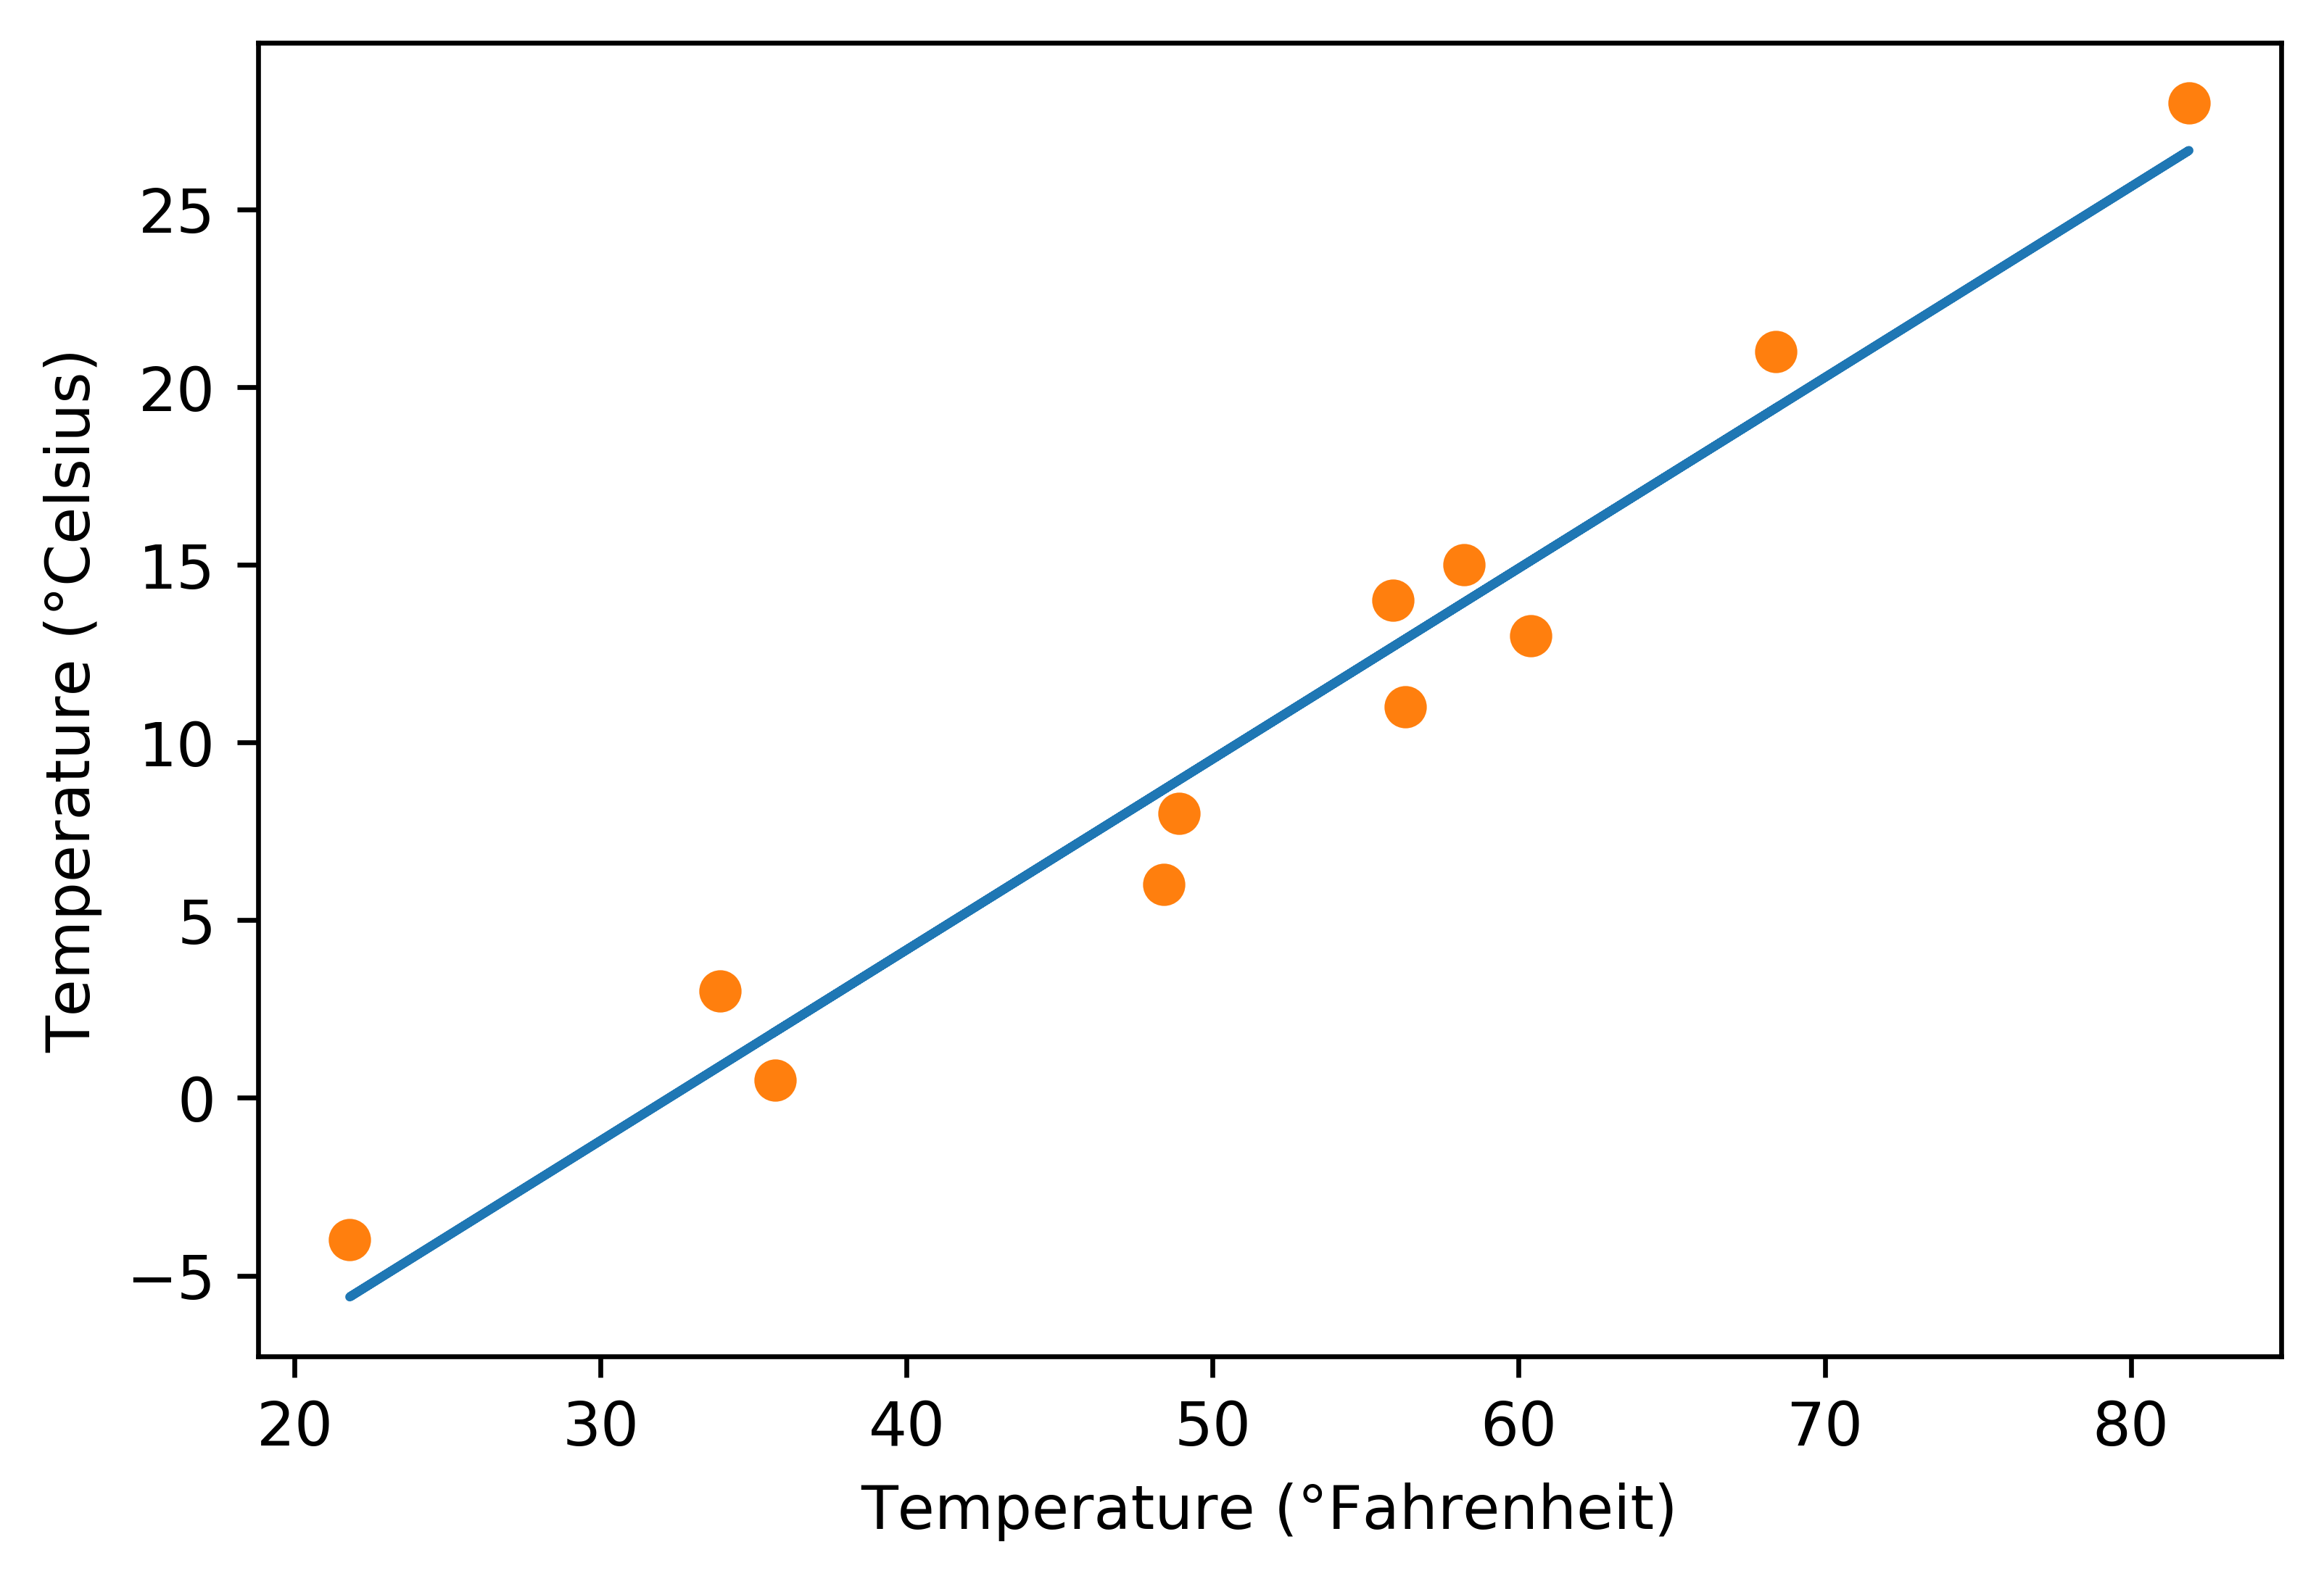

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params) # Remember that we’re training on the normalized unknown units. We also use argument unpacking.
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

## 5.5 PyTorch’s autograd: Backpropagating all things
Even if we have a complicated model with millions of parameters, as long as our model is differentiable, computing the gradient of the loss with respect to the parameters amounts to writing the analytical expression for the derivatives and evaluating them once. Granted, writing the analytical expression for the derivatives of a very deep composition of linear and nonlinear functions is not a lot of fun. It isn’t particularly quick, either.

### 5.5.1 Computing the gradient automatically
This is when PyTorch tensors come to the rescue, with a PyTorch component called
`autograd`. Chapter 3 presented a comprehensive overview of what tensors are and what
functions we can call on them. We left out one very interesting aspect, however:
PyTorch tensors can remember where they come from, in terms of the operations and
parent tensors that originated them, and they can automatically provide the chain of
derivatives of such operations with respect to their inputs.

**APPLYINGAUTOGRAD**

At this point, the best way to proceed is to rewrite our thermometer calibration code,
this time using autograd, and see what happens. First, we recall our model and loss
function.

In [21]:
def model(t_u, w, b):
    return w * t_u + b

In [22]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [23]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

**USING THE GRAD ATTRIBUTE**

Notice the `requires_grad=True` argument to the tensor constructor? That argument
is telling PyTorch to track the entire family tree of tensors resulting from operations
on `params` . In other words, any tensor that will have `params` as an ancestor will have
access to the chain of functions that were called to get from params to that tensor. In
case these functions are differentiable (and most PyTorch tensor operations will be),
the value of the derivative will be automatically populated as a grad attribute of the
`params` tensor.

In general, all PyTorch tensors have an attribute named `grad` . Normally, it’s `None` :

In [24]:
params.grad is None

True

All we have to do to populate it is to start with a tensor with `requires_grad` set to
`True` , then call the model and compute the loss, and then call `backward` on the `loss`
tensor:

In [25]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
params.grad

/home/hoai_tran/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


tensor([4517.2969,   82.6000])

At this point, the `grad` attribute of `params` contains the derivatives of the loss with
respect to each element of params.

When we compute our `loss` while the parameters `w` and `b` require gradients, in
addition to performing the actual computation, PyTorch creates the autograd graph
with the operations (in black circles) as nodes, as shown in the top row of fig-
ure 5.10. When we call `loss.backward()` , PyTorch traverses this graph in the reverse
direction to compute the gradients, as shown by the arrows in the bottom row of
the figure.

![](images/5.7.png)

Figure 5.10 The forward graph and backward graph of the model as computed with autograd

**ACCUMULATING GRAD FUNCTIONS**

We could have any number of tensors with `requires_grad` set to `True` and any composition of functions. In this case, PyTorch would compute the derivatives of the loss
throughout the chain of functions (the computation graph) and accumulate their values in the `grad` attribute of those tensors (the leaf nodes of the graph).

>**WARNING**: Calling `backward` will lead derivatives to `accumulate` at leaf nodes.
We need to **zero the gradient explicitly** after using it for parameter updates.

Let’s repeat together: calling `backward` will lead derivatives to `accumulate` at leaf nodes. So if `backward` was called earlier, the loss is evaluated again, `backward` is called again (as in any training loop), and the gradient at each leaf is accumulated (that is, summed) on top of the one computed at the previous iteration, which leads to an
incorrect value for the gradient.

In order to prevent this from occurring, we need to **zero the gradient explicitly** at each iteration. We can do this easily using the in-place `zero_` method:

In [26]:
if params.grad is not None:
    params.grad.zero_()

> **Note**: You might be curious why zeroing the gradient is a required step instead of zeroing happening automatically whenever we call `backward` . Doing it this way provides more flexibility and control when working with gradients in complicated models.

Having this reminder drilled into our heads, let’s see what our autograd-enabled
training code looks like, start to finish:

In [27]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None: # This could be done at any point in the
            params.grad.zero_()     # loop prior to calling loss.backward().

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
                                                   # This is a somewhat cumbersome bit
        with torch.no_grad():                      # of code, but as we’ll see in the next                                                                       
            params -= learning_rate * params.grad  # section, it’s not an issue in practice.

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

Note that our code updating `params` is not quite as straightforward as we might have expected. There are two particularities. First, we are encapsulating the update in a `no_grad` context using the Python with statement. This means within the with block, the PyTorch autograd mechanism should **look away**: that is, not add edges to the forward graph. In fact, when we are executing this bit of code, the forward graph that PyTorch records is consumed when we call `backward`, leaving us with the `params` leaf node. But now we want to change this leaf node before we start building a fresh forward graph on top of it. While this use case is usually wrapped inside the optimizers we discuss in section 5.5.2, we will take a closer look when we see another common use of `no_grad` in section 5.5.4.

In [29]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True), # requires_grad=True is key.
    t_u = t_un,    # Again, we’re using the normalized t_un instead of t_u.
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

The result is the same as we got previously. Good for us! It means that while we are
*capable* of computing derivatives by hand, we no longer need to.

### 5.5.2 Optimizers a la carte
In the example code, we used **vanilla gradient descent** for optimization, which worked
fine for our simple case. Needless to say, there are several optimization strategies and
tricks that can assist convergence, especially when models get complicated.

We’ll dive deeper into this topic in later chapters, but now is the right time to
introduce the way PyTorch abstracts the optimization strategy away from user code:
that is, the training loop we’ve examined. This saves us from the boilerplate busywork
of having to update each and every parameter to our model ourselves. The `torch`
module has an `optim` submodule where we can find classes implementing different
optimization algorithms.

In [30]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_multi_tensor',
 'functional',
 'lr_scheduler',
 'swa_utils']

Every optimizer constructor takes a list of parameters (aka PyTorch tensors, typically with `requires_grad` set to `True` ) as the first input. All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values and access their grad attribute, as represented in figure 5.11.

![](images/5.8.png)
Figure 5.11 (A) Conceptual representation of how an optimizer holds a reference to
parameters. (B) After a loss is computed from inputs, (C) a call to `.backward` leads to
`.grad` being populated on parameters. (D) At that point, the optimizer can access
`.grad` and compute the parameter updates.

Each optimizer exposes two methods: `zero_grad` and `step . zero_grad` zeroes the
`grad` attribute of all the parameters passed to the optimizer upon construction. `step` updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.

**USING A GRADIENT DESCENT OPTIMIZER**

Let’s create params and instantiate a gradient descent optimizer:

In [31]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

Here SGD stands for **stochastic gradient descent**. Actually, the optimizer itself is exactly a vanilla gradient descent (as long as the `momentum` argument is set to `0.0` , which is the default). The term **stochastic** comes from the fact that the gradient is typically obtained by averaging over a random subset of all input samples, called a `minibatch`. However, the optimizer does not know if the loss was evaluated on all the samples (vanilla) or a random subset of them (stochastic), so the algorithm is literally the same in the two cases.

In [32]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

The value of `params` is updated upon calling `step` without us having to touch it ourselves! What happens is that the optimizer looks into `params.grad` and updates
`params` , subtracting `learning_rate` times `grad` from it, exactly as in our former hand-
rolled code.

Ready to stick this code in a training loop? Nope! The big gotcha almost got us we forgot to zero out the gradients. Had we called the previous code in a loop, gradients would have accumulated in the leaves at every call to `backward` , and our gradient
descent would have been all over the place! Here’s the loop-ready code, with the extra
`zero_grad` at the correct spot (right before the call to `backward` ):

In [33]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # As before, the exact placement of this call is somewhat arbitrary. 
                      # It could be earlier in the loop as well.
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

Perfect! See how the optim module helps us abstract away the specific optimization
scheme? All we have to do is provide a list of params to it (that list can be extremely long, as is needed for very deep neural network models), and we can forget about the
details.

In [34]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [35]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
# It’s important that both params are the same object; 
# otherwise the optimizer won’t know what parameters were used by the model.
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

**TESTING OTHER OPTIMIZERS**

In order to test more optimizers, all we have to do is instantiate a different optimizer,
say **Adam** , instead of **SGD** . The rest of the code stays as it is. Pretty handy stuff.

We won’t go into much detail about Adam; suffice to say that it is a more sophisticated optimizer in which the learning rate is set adaptively. In addition, it is a lot less
sensitive to the scaling of the parameters—so insensitive that we can go back to using the original (non-normalized) input `t_u` , and even increase the learning rate to `1e-1` ,
and Adam won’t even blink:

In [36]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate) # New optimizer class

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u, # We’re back to the original t_u as our input.
    t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

The optimizer is not the only flexible part of our training loop. Let’s turn our atten-
tion to the model. In order to train a neural network on the same data and the same
loss, all we would need to change is the `model` function. It wouldn’t make particular
sense in this case, since we know that converting Celsius to Fahrenheit amounts to a
linear transformation, but we’ll do it anyway in chapter 6. We’ll see quite soon that
neural networks allow us to remove our arbitrary assumptions about the shape of the
function we should be approximating. Even so, we’ll see how neural networks manage
to be trained even when the underlying processes are highly nonlinear (such in the
case of describing an image with a sentence, as we saw in chapter 2).

### 5.5.3 Training, validation, and overfitting
Johannes Kepler taught us one last thing that we didn’t discuss so far, remember? He kept part of the data on the side so that he could validate his models on independent observations. This is a vital thing to do, especially when the model we adopt could potentially approximate functions of any shape, as in the case of neural networks. In other words, a highly adaptable model will tend to use its many parameters to make sure the loss is minimal at the data points, but we’ll have no guarantee that the model behaves well **away from** or **in between** the data points. After all, that’s what we’re asking the optimizer to do: minimize the loss at the data points. Sure enough, if we had independent data points that we didn’t use to evaluate our loss or descend along its negative gradient, we would soon find out that evaluating the loss at those independent data points would yield higher-than-expected loss. We have already mentioned this phenomenon, called **overfitting**.

![](images/5.9.png)

**EVALUATING THE TRAINING LOSS**

The training loss will tell us if our model can fit the training set at all—in other words, if our model has enough capacity to process the relevant information in the data. If our mysterious thermometer somehow managed to measure temperatures using a logarithmic scale, our poor linear model would not have had a chance to fit those measurements and provide us with a sensible conversion to Celsius. In that case, our training loss (the loss we were printing in the training loop) would stop decreasing well before approaching zero.

**GENERALIZING TO THE VALIDATION SET**

What about the validation set? Well, if the loss evaluated in the validation set doesn’t decrease along with the training set, it means our model is improving its fit of the samples it is seeing during training, but it is not generalizing to samples outside this precise set. As soon as we evaluate the model at new, previously unseen points, the values of the loss function are poor. So, rule 2: if the training loss and the validation loss diverge, we’re overfitting.

We’ve got some nice trade-offs here. On the one hand, we need the model to have enough capacity for it to fit the training set. On the other, we need the model to avoid overfitting. Therefore, in order to choose the right size for a neural network model in
terms of parameters, the process is based on two steps: increase the size until it fits, and then scale it down until it stops overfitting. 

We’ll see more about this in chapter 12—we’ll discover that our life will be a balancing act between fitting and overfitting. For now, let’s get back to our example and see how we can split the data into a training set and a validation set. We’ll do it by shuffling `t_u` and `t_c` the same way and then splitting the resulting shuffled tensors into two parts.

**SPLITTING A DATASET**

Shuffling the elements of a tensor amounts to finding a permutation of its indices.
The `randperm` function does exactly this:

In [37]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices  # Since these are random, don’t
                            # be surprised if your values end
                            # up different from here on out.

(tensor([7, 2, 9, 8, 4, 3, 5, 1, 0]), tensor([10,  6]))

We just got index tensors that we can use to build training and validation sets starting
from the data tensors:

In [38]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

Our training loop doesn’t really change. We just want to additionally evaluate the validation loss at every epoch, to have a chance to recognize whether we’re overfitting:

In [40]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)      # These two pairs of lines are the
        train_loss = loss_fn(train_t_p, train_t_c) # same except for the train_* vs. val_*inputs
                                                
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()  # Note that there is no val_loss.backward()
        train_loss.backward()  # here, since we don’t want to train the
        optimizer.step()       # model on the validation data.


        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                f" Validation loss {val_loss.item():.4f}")
    return params

In [41]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,  # Since we’re using SGD again, we’re
    val_t_u = val_t_un,      # back to using normalized inputs.
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 75.9278, Validation loss 100.3288
Epoch 2, Training loss 37.4690, Validation loss 45.1741
Epoch 3, Training loss 31.4738, Validation loss 32.5256
Epoch 500, Training loss 8.0829, Validation loss 6.6445
Epoch 1000, Training loss 3.6888, Validation loss 4.2357
Epoch 1500, Training loss 2.8342, Validation loss 4.4852
Epoch 2000, Training loss 2.6680, Validation loss 4.8504
Epoch 2500, Training loss 2.6356, Validation loss 5.0611
Epoch 3000, Training loss 2.6293, Validation loss 5.1637


tensor([  5.3972, -17.8577], requires_grad=True)

Here we are not being entirely fair to our model. The validation set is really small, so
the validation loss will only be meaningful up to a point. In any case, we note that the
validation loss is higher than our training loss, although not by an order of magni-
tude. We expect a model to perform better on the training set, since the model
parameters are being shaped by the training set. Our main goal is to also see both the
training loss and the validation loss decreasing. While ideally both losses would be
roughly the same value, as long as the validation loss stays reasonably close to the
training loss, we know that our model is continuing to learn generalized things about
our data. In figure 5.14, case C is ideal, while D is acceptable. In case A, the model
isn’t learning at all; and in case B, we see overfitting. We’ll see more meaningful exam-
ples of overfitting in chapter 12.

![](images/5.10.png)

Figure 5.14 Overfitting scenarios when looking at the training (solid line) and validation (dotted line)
losses. (A) Training and validation losses do not decrease; the model is not learning due to no
information in the data or insufficient capacity of the model. (B) Training loss decreases while
validation loss increases: overfitting. (C) Training and validation losses decrease exactly in tandem.
Performance may be improved further as the model is not at the limit of overfitting. (D) Training and
validation losses have different absolute values but similar trends: overfitting is under control.

### 5.5.4 Autograd nits and switching it off
The first line in the training loop evaluates `model`
on `train_t_u` to produce `train_t_p` . Then `train_loss` is evaluated from `train_t_p` .
This creates a computation graph that links `train_t_u` to `train_t_p` to `train_loss` .
When model is evaluated again on `val_t_u` , it produces `val_t_p` and `val_loss` . In this
case, a separate computation graph will be created that links `val_t_u` to `val_t_p` to
`val_loss` . Separate tensors have been run through the same functions, model and
`loss_fn` , generating separate computation graphs, as shown in figure 5.15.

![](images/5.11.png)

Figure 5.15 Diagram showing how gradients propagate through a graph with two
losses when .backward is called on one of them

The only tensors these two graphs have in common are the parameters. When we call `backward` on `train_loss` , we run `backward` on the first graph. In other words, we accumulate the derivatives of `train_loss` with respect to the parameters based on the computation generated from `train_t_u`.

If we (incorrectly) called `backward` on `val_loss` as well, we would accumulate the
derivatives of `val_loss` with respect to the parameters **on the same leaf nodes**. Remember
the `zero_grad` thing, whereby gradients are accumulated on top of each other every
time we call backward unless we zero out the gradients explicitly? Well, here something very similar would happen: calling `backward` on `val_loss` would lead to gradients accumulating in the params tensor, on top of those generated during the `train_loss.backward()` call. In this case, we would effectively train our model on the whole dataset (both training and validation), since the gradient would depend on both. Pretty interesting.

There’s another element for discussion here. Since we’re not ever calling `backward` on `val_loss`, why are we building the graph in the first place? We could in fact
just call `model` and `loss_fn` as plain functions, without tracking the computation.
However optimized, building the autograd graph comes with additional costs that we
could totally forgo during the validation pass, especially when the model has millions
of parameters.
In order to address this, PyTorch allows us to switch off autograd when we don’t
need it, using the `torch.no_grad` context manager. We won’t see any meaningful
advantage in terms of speed or memory consumption on our small problem. However, for larger models, the differences can add up. We can make sure this works by
checking the value of the `requires_grad` attribute on the `val_loss` tensor:

In [42]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False  # Checks that our output requires_grad args are
                                                    # forced to False inside this block           
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

Using the related `set_grad_enabled` context, we can also condition the code to run
with autograd enabled or disabled, according to a Boolean expression—typically indi-
cating whether we are running in training or inference mode. We could, for instance,
define a `calc_forward` function that takes data as input and runs `model` and `loss_fn`
with or without autograd according to a Boolean `train_is` argument:

In [43]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

## 5.6 Conclusion
We started this chapter with a big question: how is it that a machine can learn from
examples? We spent the rest of the chapter describing the mechanism with which a
model can be optimized to fit data. We chose to stick with a simple model in order to
see all the moving parts without unneeded complications.

## 5.7 Exercise
1. Redefine the model to be `w2 * t_u ** 2 + w1 * t_u + b`.
* a.What parts of the training loop, and so on, need to change to accommodate this redefinition?
* b. What parts are agnostic to swapping out the model?
* c. Is the resulting loss higher or lower after training?
* d. Is the actual result better or worse?

## 5.8 Summary
* Linear models are the simplest reasonable model to use to fit data.
* Convex optimization techniques can be used for linear models, but they do not generalize to neural networks, so we focus on stochastic gradient descent for parameter estimation.
* Deep learning can be used for generic models that are not engineered for solving a specific task, but instead can be automatically adapted to specialize themselves on the problem at hand.
* Learning algorithms amount to optimizing parameters of models based on observations. A loss function is a measure of the error in carrying out a task, such as the error between predicted outputs and measured values. The goal is to get the loss function as low as possible.
* The rate of change of the loss function with respect to the model parameters can be used to update the same parameters in the direction of decreasing loss.
* The `optim` module in PyTorch provides a collection of ready-to-use optimizers for updating parameters and minimizing loss functions.
* Optimizers use the autograd feature of PyTorch to compute the gradient for each parameter, depending on how that parameter contributes to the final output. This allows users to rely on the dynamic computation graph during complex forward passes.
* Context managers like with `torch.no_grad()`: can be used to control auto-grad’s behavior.
* Data is often split into separate sets of training samples and validation samples. This lets us evaluate a model on data it was not trained on.
* Overfitting a model happens when the model’s performance continues to improve on the training set but degrades on the validation set. This is usually due to the model not generalizing, and instead memorizing the desired outputs for the training set.